# Проект: Многоцелевая модель для NER + event-CLS


In [ ]:
!pip install seqeval -q

In [ ]:
!wget -O train.jsonl "https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/train.jsonl"
!wget -O dev.jsonl "https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/dev.jsonl"
!wget -O test.jsonl "https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/test.jsonl"
!wget -O ent_types.jsonl "https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/ent_types.jsonl"
!wget -O rel_types.jsonl "https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/rel_types.jsonl"

--2025-11-05 11:31:18--  https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/train.jsonl
Resolving huggingface.co (huggingface.co)... 18.165.122.120, 18.165.122.101, 18.165.122.30, ...
Connecting to huggingface.co (huggingface.co)|18.165.122.120|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /api/resolve-cache/datasets/iluvvatar/NEREL/b8bbfeb80905e6d66dc06a47ec6e37b502ea6c69/data%2Ftrain.jsonl?%2Fdatasets%2Filuvvatar%2FNEREL%2Fresolve%2Fmain%2Fdata%2Ftrain.jsonl=&etag=%22bd19e471916b2f13bf4db564cc9ae686b8bcaa8f%22 [following]
--2025-11-05 11:31:18--  https://huggingface.co/api/resolve-cache/datasets/iluvvatar/NEREL/b8bbfeb80905e6d66dc06a47ec6e37b502ea6c69/data%2Ftrain.jsonl?%2Fdatasets%2Filuvvatar%2FNEREL%2Fresolve%2Fmain%2Fdata%2Ftrain.jsonl=&etag=%22bd19e471916b2f13bf4db564cc9ae686b8bcaa8f%22
Reusing existing connection to huggingface.co:443.
HTTP request sent, awaiting response... 200 OK
Length: 7570232 (7.2M) [text/plain]
S

#### Структура ноутбука

1. Подготовка окружения (пути, seed, imports)
2. EDA - загрузка jsonl, обзор, графики, выводы
3. Парсинг и таргеты
4. Токенизация, выравнивание меток, DataLoader
5. Реализация модели и кастомного loss (uncertainty-weighting) -
6. Тренировка/валидация - training loop, оптимизатор, scheduler, логирование метрик
7. Инференс и анализ ошибок -  inference pipeline и примеры



##### 1. EDA

Цели:

- Прочитать первые 50–200 записей `train.jsonl` (путь `/data/train.jsonl`).
- Посчитать частоты: entity types, relation/event types.
- Построить графики: топ-15 entity types, распределение длины текстов, число сущностей на документ.
- Написать 2–3 коротких вывода в Markdown: что можно ожидать при моделировании (редкие типы, длинные документы и т. п.).




**Прочитаем все записи из файлов и посмотрим на примеры записей из train.jsonl**

In [ ]:
import json

def read_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return data


train = read_jsonl('train.jsonl')
val = read_jsonl('dev.jsonl')
test = read_jsonl('test.jsonl')
ent_types = read_jsonl('ent_types.jsonl')
rel_types = read_jsonl('rel_types.jsonl')

print(f"Train: {len(train)} примеров")
print(f"Dev: {len(val)} примеров")
print(f"Test: {len(test)} примеров")

Train: 746 примеров
Dev: 94 примеров
Test: 93 примеров


In [ ]:
train[:50]

[{'id': 0,
  'text': 'Пулеметы, автоматы и снайперские винтовки изъяты в арендуемом американцами доме в Бишкеке\n\n05/08/2008 10:35\n\nБИШКЕК, 5 августа /Новости-Грузия/. Правоохранительные органы Киргизии обнаружили в доме, арендуемом гражданами США в Бишкеке, пулеметы, автоматы и снайперские винтовки, сообщает во вторник пресс-служба МВД Киргизии.\n\n"В ходе проведения оперативно-профилактического мероприятия под кодовым названием "Арсенал" в новостройке Ынтымак, в доме, принадлежащем 66-летнему гражданину Киргизии и арендуемом гражданами США, обнаружены и изъяты: шесть крупнокалиберных пулеметов с оптическим прицелом и с приборами ночного видения, 26 автоматов калибра 5,56 миллиметра, два винчестера марки МОСВЕГА 12-го калибра, четыре ствола от крупнокалиберного пулемета, два подствольных гранатомета, четыре снайперские винтовки с оптическим прицелом защитного цвета, шесть пистолетов калибра 9 миллиметров марки Беретта, одна винтовка", - говорится в сообщении МВД.\n\nПресс-служба от

**Посчитаем частоты: entity types, relation/event types.**

In [ ]:
len(ent_types)

29

In [ ]:
len(rel_types)

49

In [ ]:
rel_types

[{'type': 'ABBREVIATION', 'arg1': ['<ENTITY>'], 'arg2': ['<ENTITY>']},
 {'type': 'KNOWS', 'arg1': ['PERSON', 'PROFESSION'], 'arg2': ['<ENTITY>']},
 {'type': 'AGE_IS', 'arg1': ['<ENTITY>'], 'arg2': ['AGE']},
 {'type': 'AGE_DIED_AT', 'arg1': ['PERSON', 'PROFESSION'], 'arg2': ['AGE']},
 {'type': 'ALTERNATIVE_NAME', 'arg1': ['<ENTITY>'], 'arg2': ['<ENTITY>']},
 {'type': 'AWARDED_WITH',
  'arg1': ['PERSON',
   'PROFESSION',
   'ORGANIZATION',
   'WORK_OF_ART',
   'NATIONALITY'],
  'arg2': ['AWARD']},
 {'type': 'PLACE_OF_BIRTH',
  'arg1': ['PERSON', 'PROFESSION'],
  'arg2': ['CITY',
   'COUNTRY',
   'DISTRICT',
   'FACILITY',
   'LOCATION',
   'STATE_OR_PROVINCE']},
 {'type': 'CAUSE_OF_DEATH',
  'arg1': ['PERSON', 'PROFESSION', 'NATIONALITY'],
  'arg2': ['DISEASE', 'EVENT']},
 {'type': 'DATE_DEFUNCT_IN',
  'arg1': ['CITY',
   'COUNTRY',
   'DISTRICT',
   'FACILITY',
   'EVENT',
   'ORGANIZATION',
   'STATE_OR_PROVINCE',
   'WORK_OF_ART'],
  'arg2': ['DATE']},
 {'type': 'DATE_FOUNDED_IN',
  '

In [ ]:
ent_types

[{'type': 'AGE', 'link': ''},
 {'type': 'AWARD', 'link': '<NORM>:Wikidata'},
 {'type': 'CITY', 'link': '<NORM>:Wikidata'},
 {'type': 'COUNTRY', 'link': '<NORM>:Wikidata'},
 {'type': 'CRIME', 'link': ''},
 {'type': 'DATE', 'link': ''},
 {'type': 'DISEASE', 'link': '<NORM>:Wikidata'},
 {'type': 'DISTRICT', 'link': '<NORM>:Wikidata'},
 {'type': 'EVENT', 'link': '<NORM>:Wikidata'},
 {'type': 'FACILITY', 'link': '<NORM>:Wikidata'},
 {'type': 'FAMILY', 'link': ''},
 {'type': 'IDEOLOGY', 'link': '<NORM>:Wikidata'},
 {'type': 'LANGUAGE', 'link': '<NORM>:Wikidata'},
 {'type': 'LAW', 'link': '<NORM>:Wikidata'},
 {'type': 'LOCATION', 'link': '<NORM>:Wikidata'},
 {'type': 'MONEY', 'link': ''},
 {'type': 'NATIONALITY', 'link': '<NORM>:Wikidata'},
 {'type': 'NUMBER', 'link': ''},
 {'type': 'ORDINAL', 'link': ''},
 {'type': 'ORGANIZATION', 'link': '<NORM>:Wikidata'},
 {'type': 'PENALTY', 'link': ''},
 {'type': 'PERCENT', 'link': ''},
 {'type': 'PERSON', 'link': '<NORM>:Wikidata'},
 {'type': 'PRODUCT'

**Перейдем к графикам: построим топ-15 entity types, распределение длины текстов, число сущностей на документ.**

In [ ]:
from collections import Counter

def get_counts(train):
  ent_types_cnt = Counter()
  texts_len = {}
  ent_per_doc = {}
  for data in train:
    texts_len[data['id']] = len(data['text'])
    ent_per_doc[data['id']] = len(data['entities'])
    for ent in data['entities']:
      ent_type = ent.split('\t')[1].split()[0]
      ent_types_cnt[ent_type] += 1

  return ent_types_cnt, texts_len, ent_per_doc


In [ ]:
ent_types_cnt, texts_len, ent_per_doc = get_counts(train)

In [ ]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 3.8 MB/s eta 0:00:00a 0:00:01


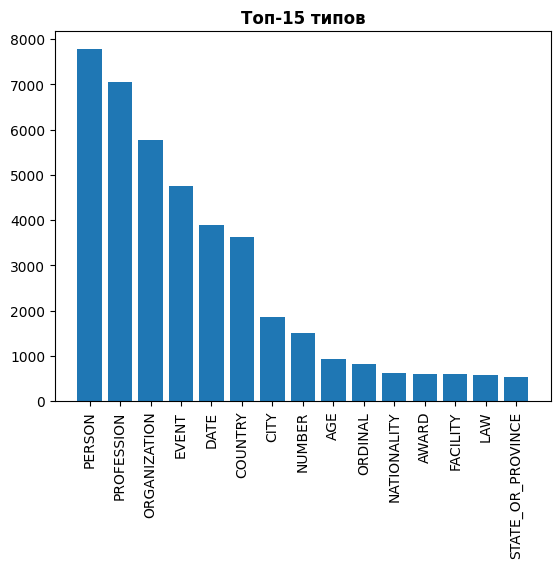

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

top15 = dict(ent_types_cnt.most_common(15))
plt.bar(top15.keys(), top15.values())
plt.title("Топ-15 типов", fontweight='bold')
plt.xticks(rotation=90);

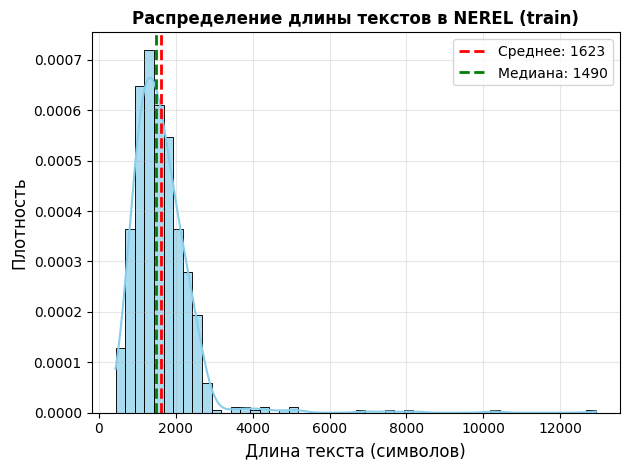

In [ ]:
lengths = list(texts_len.values())

sns.histplot(lengths, bins=50, kde=True, color='skyblue', edgecolor='black', alpha=0.7, stat='density')

plt.axvline(np.mean(lengths), color='red', linestyle='--', linewidth=2, label=f'Среднее: {np.mean(lengths):.0f}')
plt.axvline(np.median(lengths), color='green', linestyle='--', linewidth=2, label=f'Медиана: {np.median(lengths):.0f}')

plt.title('Распределение длины текстов в NEREL (train)', fontweight='bold')
plt.xlabel('Длина текста (символов)', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

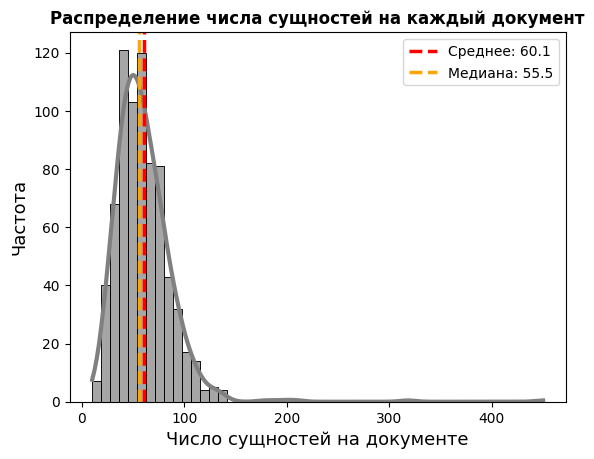

In [ ]:
mean_val = np.mean(list(ent_per_doc.values()))
median_val = np.median(list(ent_per_doc.values()))
ax = sns.histplot(ent_per_doc, bins=50, kde=True, color='grey', alpha=0.7,
                  line_kws={'linewidth': 3}, edgecolor='black')
ax.axvline(mean_val, color='red', linestyle='--', linewidth=2.5, label=f'Среднее: {mean_val:.1f}')
ax.axvline(median_val, color='orange', linestyle='--', linewidth=2.5, label=f'Медиана: {median_val:.1f}')
plt.legend()
plt.title('Распределение числа сущностей на каждый документ', fontweight='bold')
plt.xlabel('Число сущностей на документе', fontsize=13)
plt.ylabel('Частота', fontsize=13);

**Вывод на основании этих данных и графиков:**
1. Типы сущностей
- Доминируют: PERSON, PROFESSION, ORGANIZATION
- Редкие: FAMILY, LANGUAGE

2. Длина текстов
- Средняя длина: 1623 символа
- 95% текстов ≤ 4000 символов, но имеем длинный хвост справа, влоть до 12000 символов

3. Число сущностей на документ
- В целом число сущностей достигает в среднем 60
- В 95% документов число сущностей ≤ 150, также имеем перекос в правую сторону до 450 сущностей примерно

##### Парсинг и подготовка таргетов

Ниже - две заранее подготовленные функции парсинга строкового формата NEREL. Их вы получаете и можете использовать сразу (не меняйте имена).

Ожидаемые дополнительные функции, которые вы должны реализовать:

- `build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]` - для каждого документа вернуть словарь с полями: `text`, `tokens` (word-tokenization по пробелам), `token_spans` (символьные оффсеты слов), `tags` (BIO per token), `cls_vec` (multihot длиной len(event_list)).

- `make_event_list(records, K=30)` - собрать топ-K типов событий/relations и вернуть список.



**Правила BIO и сопоставления:**

- Токенизация для BIO - простая `text.split()` (по пробелам). Офсеты токенов вычисляются на основе поиска токена в тексте (учтите повторы; используйте скользящий указатель).
- Для каждой сущности (start, end - символьные оффсеты) пометьте токены, которые пересекаются с интервалом сущности.
- Метки: `B-TYPE`, `I-TYPE`, `O`.



*Чтобы построить функцию build_examples_from_nerel, для которой требуется cls_vec, напишем функции для вычисления event_list и cls_vec. В чем логика: буду по лемме сопоставлять из каждой записи relations к rel_types, и соотвественно event_list и cls_vec будем строить на основе rel_types*

In [ ]:
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 28.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.8/204.8 KB 3.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 48.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 795.1/795.1 KB 12.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.4/463.4 KB 6.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 44.1 MB/s eta 0:00:000

In [ ]:
!python -m spacy download ru_core_news_sm

/bin/bash: line 1: python: command not found


In [ ]:
import spacy
import subprocess
import sys
from collections import defaultdict
from typing import List
import json

subprocess.run([sys.executable, "-m", "spacy", "download", "ru_core_news_sm"])
nlp = spacy.load("ru_core_news_sm")

def extract_root(rel_type):
    rel_clean = rel_type.replace("_", " ").lower()
    doc = nlp(rel_clean)
    for token in doc:
        if token.pos_ == "VERB":
            return token.lemma_.upper()
    return rel_type.split("_")[0]

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 KB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 49.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [ ]:
event_list = [rel["type"] for rel in rel_types]
event_list = sorted(event_list)

root_to_rel = {}

for rel in rel_types:
    rel_type = rel["type"]
    root = extract_root(rel_type)
    root_to_rel[root] = rel_type


for i, (k, v) in enumerate(list(root_to_rel.items())[:5]):
    print(f"  '{k}' → '{v}'")


print(f'Длина event_list: {len(event_list)}')

  'ABBREVIATION' → 'ABBREVIATION'
  'KNOWS' → 'KNOWS'
  'AGE' → 'AGE_DIED_AT'
  'ALTERNATIVE' → 'ALTERNATIVE_NAME'
  'AWARDED' → 'AWARDED_WITH'
Длина event_list: 49


In [ ]:
def create_cls_vec_from_relations(example, event_list):
    vec = [0] * len(event_list)

    for rel_line in example.get('relations', []):
        parts = rel_line.split('\t')
        if len(parts) < 2:
            continue
        rel_type = parts[1].split()[0]

        if rel_type in event_list:
            idx = event_list.index(rel_type)
            vec[idx] = 1

    return vec


*Проверим работу функций:*

In [ ]:
print("\nПроверка train[0]:")
print("Текст:", train[0]['text'])

print(create_cls_vec_from_relations(train[0], event_list))


Проверка train[0]:
Текст: Пулеметы, автоматы и снайперские винтовки изъяты в арендуемом американцами доме в Бишкеке

05/08/2008 10:35

БИШКЕК, 5 августа /Новости-Грузия/. Правоохранительные органы Киргизии обнаружили в доме, арендуемом гражданами США в Бишкеке, пулеметы, автоматы и снайперские винтовки, сообщает во вторник пресс-служба МВД Киргизии.

"В ходе проведения оперативно-профилактического мероприятия под кодовым названием "Арсенал" в новостройке Ынтымак, в доме, принадлежащем 66-летнему гражданину Киргизии и арендуемом гражданами США, обнаружены и изъяты: шесть крупнокалиберных пулеметов с оптическим прицелом и с приборами ночного видения, 26 автоматов калибра 5,56 миллиметра, два винчестера марки МОСВЕГА 12-го калибра, четыре ствола от крупнокалиберного пулемета, два подствольных гранатомета, четыре снайперские винтовки с оптическим прицелом защитного цвета, шесть пистолетов калибра 9 миллиметров марки Беретта, одна винтовка", - говорится в сообщении МВД.

Пресс-служба отмеч

**Перейдем к написанию build_examples_from_nerel и make_event_list**

In [ ]:

import re
from collections import Counter

def parse_entity_line(line: str):
    parts = line.split('\t')
    if len(parts) < 3:
        return None
    ent_id = parts[0].strip()
    type_pos = parts[1].strip()
    text = parts[2].strip() if len(parts) > 2 else ''
    m = re.match(r'(\S+)\s+(\d+)\s+(\d+)', type_pos)
    if not m:
        return None
    ent_type = m.group(1)
    start = int(m.group(2))
    end = int(m.group(3))
    return {'id': ent_id, 'type': ent_type, 'start': start, 'end': end, 'text': text}

def parse_relation_line(line: str):
    parts = line.split('\t')
    if len(parts) < 2:
        return None
    rel_id = parts[0].strip()
    body = parts[1].strip()
    m = re.match(r'(\S+)\s+Arg1:(\S+)\s+Arg2:(\S+)', body)
    if not m:
        return None
    rel_type = m.group(1)
    arg1 = m.group(2); arg2 = m.group(3)
    return {'id': rel_id, 'type': rel_type, 'arg1': arg1, 'arg2': arg2}



In [ ]:
def build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]:

    list_of_dicts = []

    for i, rec in enumerate(records):
    text = rec['text']
    tokens = text.split()

    pos = 0
    token_spans = []
    for tok in tokens:
        end = pos + len(tok)
        token_spans.append((pos, end))
        pos = end + 1


    tags = ['O'] * len(tokens)

    for ent in rec['entities']:
        ent = parse_entity_line(ent)
        ent_start = ent['start']
        ent_end = ent['end']
        ent_type = ent['type']

        covered = []
        for i, (t_start, t_end) in enumerate(token_spans):
            if t_start < ent_end and t_end > ent_start:
                covered.append(i)
            if t_start >= ent_end:
                break

        if covered:
            tags[covered[0]] = f"B-{ent_type}"
            for i in covered[1:]:
                tags[i] = f"I-{ent_type}"


        list_of_dicts.append({
          'text': text,
          'tokens': tokens,
          'token_spans': token_spans,
          'tags': tags,
          'cls_vec': create_cls_vec_from_relations(rec, event_list)
      })


    return list_of_dicts

In [ ]:
def make_event_list(records: List[dict], K: int = 30) -> List[str]:
    counter = Counter()

    for rec in records:
        for rel_line in rec.get('relations', []):
            parts = rel_line.split('\t')
            if len(parts) < 2:
                continue
            rel_type = parts[1].split()[0]
            counter[rel_type] += 1

    top_k = counter.most_common(K)
    event_types = [rel_type for rel_type, count in top_k]

    event_types = sorted(event_types)

    print(f"make_event_list: найдено {len(counter)} уникальных, взято топ-{K}")
    print("Примеры:", event_types[:10])

    return event_types

##### 3. Токенизация и выравнивание меток

Задачи:

- Выбрать `AutoTokenizer(..., use_fast=True)`.
- Реализовать `tokenize_and_align_labels(examples, tokenizer, label2id, max_length)`:
  - Токенизировать текст (return_offsets_mapping
  - Преобразовать word-level BIO метки в token-level метки (subword → label = -100 / ignore_index, для первых субтокенов ставится соответствующий тег `B-`/`I-`)
  - Вернуть словарь с `input_ids`, `attention_mask`, `labels` (token-level), `cls_labels`

- Собрать `torch.utils.data.Dataset` и `DataLoader`. Можно использовать `DataCollatorForTokenClassification` либо сделать кастомный collator, который возвращает батчи с `cls_labels`.



In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased",
                                          use_fast=True)

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch
from typing import Dict

def tokenize_and_align_labels(
    examples: List[Dict],
    tokenizer,
    label2id: Dict[str, int],
    max_length: int=512
):

    tokenized_inputs = tokenizer(
      examples['tokens'],
      truncation=True,
      max_length=max_length,
      padding=False,
      is_split_into_words=True,
      return_offsets_mapping=True
  )

    labels = []
    cls_labels = []

    for i, (offset_mapping, word_labels, cls_vec) in enumerate(zip(
        tokenized_inputs["offset_mapping"],
        examples["tags"],
        examples["cls_vec"]
    )):

        label_ids = []
        prev_word_idx = None

        for word_idx in tokenized_inputs.word_ids(batch_index=i):
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != prev_word_idx:
                label_ids.append(label2id[word_labels[word_idx]])
            else:
                label_ids.append(-100)
            prev_word_idx = word_idx

        labels.append(label_ids)
        cls_labels.append

    tokenized_inputs["labels"] = labels
    tokenized_inputs["cls_labels"] = cls_labels

    return tokenized_inputs

In [ ]:
train_examples = build_examples_from_nerel(train, event_list)
val_examples = build_examples_from_nerel(val, event_list)
test_examples = build_examples_from_nerel(test, event_list)

In [ ]:
all_tags = set()
for ex in train_examples:
    all_tags.update(ex["tags"])

label_list = sorted(all_tags)
label2id = {tag: idx for idx, tag in enumerate(label_list)}
id2label = {idx: tag for tag, idx in label2id.items()}

In [ ]:
print(f"Тегов: {len(label2id)}")
print("Примеры:", list(label2id.items())[:5])

Тегов: 59
Примеры: [('B-AGE', 0), ('B-AWARD', 1), ('B-CITY', 2), ('B-COUNTRY', 3), ('B-CRIME', 4)]


**Создадим кастомный класс Dataset**

In [ ]:
from torch.utils.data import Dataset
from transformers import DataCollatorForTokenClassification
import torch

class NERELMTLDataset(Dataset):
    def __init__(self, examples, tokenizer, label2id, max_length=512):
        self.examples = examples
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_length = max_length

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        ex = self.examples[idx]
        return {
            "tokens": ex["tokens"],
            "tags": ex["tags"],
            "cls_vec": ex["cls_vec"]
        }

In [ ]:
train_dataset = NERELMTLDataset(train_examples, tokenizer, label2id)
val_dataset = NERELMTLDataset(val_examples, tokenizer, label2id)
test_dataset = NERELMTLDataset(test_examples, tokenizer, label2id)

In [ ]:
class MTLCollator:
    def __init__(self, tokenizer, label2id, max_length=512):
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_length = max_length

    def __call__(self, batch):
        tokens_list = [ex["tokens"] for ex in batch]
        tags_list = [ex["tags"] for ex in batch]
        cls_vecs = [ex["cls_vec"] for ex in batch]

        tokenized = self.tokenizer(
            tokens_list,
            truncation=True,
            max_length=self.max_length,
            padding=True,
            is_split_into_words=True,
            return_tensors="pt",
            return_offsets_mapping=True
        )

        labels = []
        for i in range(len(batch)):
            word_ids = tokenized.word_ids(batch_index=i)
            label_ids = []
            prev = None
            for wid in word_ids:
                if wid is None:
                    label_ids.append(-100)
                elif wid != prev:
                    label_ids.append(self.label2id[tags_list[i][wid]])
                else:
                    label_ids.append(-100)
                prev = wid
            labels.append(label_ids)

        cls_labels = torch.tensor(cls_vecs, dtype=torch.float)

        return {
            "input_ids": tokenized["input_ids"].to(device),
            "attention_mask": tokenized["attention_mask"].to(device),
            "labels": torch.tensor(labels).to(device),
            "cls_labels": cls_labels.to(device)
        }

In [ ]:
collator = MTLCollator(tokenizer, label2id)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collator)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collator)


test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collator)

   <div class="alert alert-block alert-success">
    <b></b> Данные на месте. Тут не хватило примеров для валидации корректности обработки
    </div>

##### 4. Модель: `JointModel` + custom loss (uncertainty weighting)


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel

class JointModel(nn.Module):
    def __init__(
        self,
        model_name="DeepPavlov/rubert-base-cased",
        num_token_labels=None,
        num_events=None,
        dropout_rate=0.1,
        use_uncertainty_weight=True
    ):
        super().__init__()

        self.encoder = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)

        hidden_size = self.encoder.config.hidden_size

        self.token_cls = nn.Linear(hidden_size, num_token_labels)

        self.cls_cls = nn.Linear(hidden_size, num_events)

        self.use_uncertainty_weight = use_uncertainty_weight
        if use_uncertainty_weight:
            self.log_sigma_token = nn.Parameter(torch.zeros(1))
            self.log_sigma_cls   = nn.Parameter(torch.zeros(1))

        self.token_loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
        self.cls_loss_fct   = nn.BCEWithLogitsLoss()

    def forward(
        self,
        input_ids,
        attention_mask,
        labels=None,
        cls_labels=None,
        return_dict=True
    ):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        sequence_output = outputs.last_hidden_state
        pooled_output   = outputs.pooler_output

        sequence_output = self.dropout(sequence_output)
        pooled_output   = self.dropout(pooled_output)

        token_logits = self.token_cls(sequence_output)
        cls_logits   = self.cls_cls(pooled_output)

        loss = None
        if labels is not None and cls_labels is not None:
            token_loss = self.token_loss_fct(
                token_logits.view(-1, token_logits.size(-1)),
                labels.view(-1)
            )
            cls_loss = self.cls_loss_fct(cls_logits, cls_labels)

            if self.use_uncertainty_weight:
                loss_token = torch.exp(-2 * self.log_sigma_token) * token_loss + self.log_sigma_token
                loss_cls   = torch.exp(-2 * self.log_sigma_cls)   * cls_loss   + self.log_sigma_cls
                loss = loss_token + loss_cls
            else:
                loss = token_loss + cls_loss

        if return_dict:
            return {
                "loss": loss,
                "token_logits": token_logits,
                "cls_logits": cls_logits,
                "log_sigma_token": self.log_sigma_token.item() if self.use_uncertainty_weight else None,
                "log_sigma_cls": self.log_sigma_cls.item() if self.use_uncertainty_weight else None
            }
        else:
            return (loss, token_logits, cls_logits)

In [ ]:
model = JointModel(
    num_token_labels=len(label2id),
    num_events=len(event_list),
    use_uncertainty_weight=True
).to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##### 5. Training / Validation



In [ ]:
def logits_to_tags(logits, valid_mask, id2label):
    preds = logits.argmax(-1).detach().cpu().numpy()
    mask  = valid_mask.detach().cpu().numpy()
    out = []
    for p, m in zip(preds, mask):
        seq = [id2label[int(i)] for i, mm in zip(p, m) if mm == 1]
        out.append(seq)
    return out


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=1,
    min_lr=1e-6
)

patience = 2
best_f1 = 0
wait = 0

In [ ]:
from seqeval.metrics import f1_score, precision_score, recall_score
import numpy as np
from sklearn.metrics import f1_score as sk_f1
import pandas as pd

In [ ]:
!pip install tqdm -q
from tqdm import tqdm

In [ ]:
model.train()
log_df = pd.DataFrame(columns=["epoch", "loss", "token_f1", "cls_f1", "lr"])

for epoch in range(1, 5):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Train {epoch}", leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs["loss"]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    model.eval()
    all_pred_tags, all_true_tags = [], []
    all_cls_preds, all_cls_trues = [], []


    with torch.no_grad():
        for batch in val_loader:
            outputs = model(**batch)

            valid_mask = ((batch["labels"] != -100) & (batch["attention_mask"] == 1)).to(torch.int)

            pred_tags = logits_to_tags(outputs["token_logits"], valid_mask, id2label)

            labels_np = batch["labels"].detach().cpu().numpy()
            mask_np = valid_mask.detach().cpu().numpy()
            true_tags = []

            for seq, m in zip(labels_np, mask_np):
                true_seq = [id2label[int(t)] for t, mm in zip(seq, m) if mm == 1]
                true_tags.append(true_seq)

            all_pred_tags.extend(pred_tags)
            all_true_tags.extend(true_tags)

            cls_pred = (torch.sigmoid(outputs["cls_logits"]) > 0.5).detach().cpu().numpy()
            all_cls_preds.extend(cls_pred)
            all_cls_trues.extend(batch["cls_labels"].detach().cpu().numpy())


    token_f1 = f1_score(all_true_tags, all_pred_tags)
    cls_f1 = sk_f1(np.concatenate(all_cls_trues), np.concatenate(all_cls_preds), average='micro')
    combined_f1 = (token_f1 + cls_f1) / 2

    scheduler.step(combined_f1)
    current_lr = optimizer.param_groups[0]['lr']

    if combined_f1 > best_f1:
        best_f1 = combined_f1
        wait = 0
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Лучшая модель F1: {combined_f1:.4f}")
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping на эпохе {epoch}")
            break

    log_df.loc[len(log_df)] = {
        "epoch": epoch,
        "loss": round(avg_loss, 4),
        "token_f1": round(token_f1, 4),
        "cls_f1": round(cls_f1, 4),
        "combined_f1": round(combined_f1, 4),
        "lr": f"{current_lr:.2e}"
    }

    print(f"Эпоха {epoch} | Loss: {avg_loss:.3f} | F1: {combined_f1:.4f} | Token_f1: {token_f1:.4f}, CLS_f1: {cls_f1:.4f}")

Лучшая модель F1: 0.6621
Эпоха 1 | Loss: 0.118 | F1: 0.6621 | Token_f1: 0.4564, CLS_f1: 0.8678


Лучшая модель F1: 0.6622
Эпоха 2 | Loss: -0.516 | F1: 0.6622 | Token_f1: 0.4512, CLS_f1: 0.8733


Лучшая модель F1: 0.6664
Эпоха 3 | Loss: -0.856 | F1: 0.6664 | Token_f1: 0.4627, CLS_f1: 0.8701


Эпоха 4 | Loss: -1.182 | F1: 0.6626 | Token_f1: 0.4573, CLS_f1: 0.8679


**Посмотрим на метрики на всех тестовых данных**

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_pred_tags, all_true_tags = [], []
all_cls_preds, all_cls_trues = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test", leave=False):
        outputs = model(**batch)

        # NER
        valid_mask = ((batch["labels"] != -100) & (batch["attention_mask"] == 1)).to(torch.int)
        pred_tags = logits_to_tags(outputs["token_logits"], valid_mask, id2label)

        labels_np = batch["labels"].cpu().numpy()
        mask_np = valid_mask.cpu().numpy()
        true_tags = []
        for seq, m in zip(labels_np, mask_np):
            true_seq = [id2label[int(t)] for t, mm in zip(seq, m) if mm == 1]
            true_tags.append(true_seq)

        all_pred_tags.extend(pred_tags)
        all_true_tags.extend(true_tags)

        # CLS
        cls_pred = (torch.sigmoid(outputs["cls_logits"]) > 0.5).cpu().numpy()
        all_cls_preds.extend(cls_pred)
        all_cls_trues.extend(batch["cls_labels"].cpu().numpy())

token_f1 = f1_score(all_true_tags, all_pred_tags)
cls_f1 = sk_f1(np.concatenate(all_cls_trues), np.concatenate(all_cls_preds), average='micro')
combined_f1 = (token_f1 + cls_f1) / 2

**Итоговые метрики на тестовых данных**

In [ ]:
print(f"token_f1: {token_f1:.4f}")
print(f"cls_f1: {cls_f1:.4f}")
print(f"combined_f1: {combined_f1:.4f}")

token_f1: 0.4772
cls_f1: 0.8718
combined_f1: 0.6745


**Вывод по метрикам**

По результатм метрик могу сказать, что моя модель хорошо справляется с задачей классификации событий, хотя того же не могу сказать про задачу NER. В качестве гиперпараметра кол-во эпох я выбрала 4, но при наличии большего времени (увы, те 10 часов, которые у меня были для обучения модели, я использовала не очень эффективно) я бы однозначно выбрала больше эпох, 5-7

Чтобы модель лучше обучалась для NER, я бы в классе самой модели итоговый лосс рассчитала как взвешенную сумму для двух лоссов с кожффициентами 2 и 1, например (то бишь в самом методе forward loss = token_loss + cls_loss заменила бы на loss = 2*token_loss + cls_loss)

##### 6. Инференс, квантизация и анализ ошибок

Проведите качественный анализ на 8–10 примерах: где NER ошибается? Какие типы сущностей плохо определяются? Насколько квантизация может ускорить инференс и сильно ли она ухудшает модель?


*Теперь возьмем 10 примеров из тестовых данных для анализа*

In [ ]:
examples

[{'tokens': ['Словацкий',
   'тренер',
   'Жолт',
   'Хорняк',
   'возглавил',
   '"Бананц"',
   '(Ереван)',
   'Словацкий',
   'тренер',
   'Жолт',
   'Хорняк',
   'стал',
   'новым',
   'главным',
   'тренером',
   'футбольного',
   'клуба',
   '"Бананц"',
   '(Ереван).',
   'Контракт',
   'с',
   '40',
   'летним',
   'тренером',
   'был',
   'подписан',
   'по',
   'системе',
   '"1+1",',
   '-',
   'сообщает',
   'пресс-служба',
   'столичного',
   'клуба.',
   'Отметим,',
   'что',
   'на',
   'посту',
   'главного',
   'тренера',
   '"Бананца"',
   'Хорняк',
   'заменил',
   'украинского',
   'специалиста',
   'Владимира',
   'Пятенко.',
   'Напомним,',
   'что',
   'в',
   'прошедшем',
   'сезоне',
   'Хорняк',
   'тренировал',
   '"Мику",',
   'которую',
   'привел',
   'к',
   'серебряным',
   'медалям',
   'чемпионата',
   'Армении.'],
  'tags': ['B-NATIONALITY',
   'B-PROFESSION',
   'B-PERSON',
   'I-PERSON',
   'B-EVENT',
   'B-ORGANIZATION',
   'B-CITY',
   'B-NATIONALIT

In [ ]:
import random

random_indices = random.sample(range(len(test_examples)), 10)
examples = [test_examples[i] for i in random_indices]
texts = [ex["text"] for ex in examples]

In [ ]:
examples = NERELMTLDataset(examples, tokenizer, label2id)

true_tags = [ex["tags"] for ex in examples]
true_events = [ex["cls_vec"] for ex in examples]

*Инференс:*

In [ ]:
model.eval()
preds_tags = []
preds_events = []

with torch.no_grad():
    for ex in examples:
        batch = collator([ex])
        out = model(**batch)

        # для NER
        pred = out["token_logits"].argmax(-1)[0]
        mask = batch["attention_mask"][0]
        seq = []
        for t, m in zip(pred.cpu(), mask.cpu()):
            if m == 1 and t != -100:
                seq.append(id2label[t.item()])
        preds_tags.append(seq)

        # для CLS
        event_pred = (torch.sigmoid(out["cls_logits"]) > 0.5)[0].cpu().numpy()
        preds_events.append(event_pred)

In [ ]:
print("Анализ".center(80, "═"))
for i in range(10):
    print(f"\nПРИМЕР {i+1}")
    print(f"TRUE NER:  {true_tags[i][:15]}")
    print(f"PRED NER:  {preds_tags[i][:15]}")
    diff = set(true_tags[i]) - set(preds_tags[i])
    if diff:
        print(f"ОШИБКИ: пропущены типы → {diff}")
    else:
        print("NER: ОК")

    true_ev = [event_list[j] for j, v in enumerate(true_events[i]) if v]
    pred_ev = [event_list[j] for j, v in enumerate(preds_events[i]) if v]
    print(f"TRUE события: {true_ev}")
    print(f"PRED события: {pred_ev}")
    print("─" * 50)

═════════════════════════════════════Анализ═════════════════════════════════════

ПРИМЕР 1
TRUE NER:  ['B-PROFESSION', 'B-COUNTRY', 'O', 'O', 'B-CRIME', 'I-CRIME', 'O', 'B-PROFESSION', 'B-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'B-ORGANIZATION', 'O', 'O']
PRED NER:  ['I-CRIME', 'B-PROFESSION', 'B-PROFESSION', 'I-PROFESSION', 'B-COUNTRY', 'O', 'O', 'B-CRIME', 'I-CRIME', 'O', 'B-PROFESSION', 'B-PROFESSION', 'B-PERSON', 'I-PERSON', 'I-PERSON']
NER: ОК
TRUE события: ['AGENT', 'AGE_IS', 'ALTERNATIVE_NAME', 'CONVICTED_OF', 'EXPENDITURE', 'HEADQUARTERED_IN', 'INCOME', 'ORGANIZES', 'ORIGINS_FROM', 'PARTICIPANT_IN', 'POINT_IN_TIME', 'SUBORDINATE_OF', 'TAKES_PLACE_IN', 'WORKPLACE', 'WORKS_AS']
PRED события: ['AGENT', 'AGE_IS', 'ALTERNATIVE_NAME', 'CONVICTED_OF', 'EXPENDITURE', 'HAS_CAUSE', 'HEADQUARTERED_IN', 'LOCATED_IN', 'ORIGINS_FROM', 'PARTICIPANT_IN', 'PENALIZED_AS', 'PLACE_RESIDES_IN', 'POINT_IN_TIME', 'SUBORDINATE_OF', 'TAKES_PLACE_IN', 'WORKPLACE', 'WORKS_AS']
─────────────────────────────

In [ ]:
!pip install bitsandbytes

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 21.0 MB/s eta 0:00:0000:0100:01


**Приступим к квантизации**

Я выбрала квантизацию через bitsandbytes (замена nn.Linear на 8-битные слои), потому что это самый простой способ запустить инт8-подобный инференс прямо на видеокарте, почти без переписывания кода и в целом с экономией видеопамяти

In [ ]:
import bitsandbytes as bnb

def to_8bit_linear(module: nn.Module):
    for name, child in list(module.named_children()):
        if isinstance(child, nn.Linear):
            try:
                new_lin = bnb.nn.Linear8bitLt(
                    child.in_features, child.out_features, (child.bias is not None), False
                )
            except TypeError:
                new_lin = bnb.nn.Linear8bitLt(child.in_features, child.out_features, (child.bias is not None))

            with torch.no_grad():
                new_lin.weight = bnb.nn.Int8Params(
                    child.weight.data.float().contiguous(), requires_grad=False
                )
                if child.bias is not None:
                    new_lin.bias = nn.Parameter(child.bias.data.float().contiguous(), requires_grad=False)

            setattr(module, name, new_lin)
        else:
            to_8bit_linear(child)
    return module

In [ ]:
import copy, time

model_fp32 = model.eval().to(device)
model_int8 = copy.deepcopy(model_fp32).to(device).eval()
model_int8 = to_8bit_linear(model_int8)

examples = []
for batch in val_loader:
    ids  = batch["input_ids"].to(device)
    mask = batch["attention_mask"].to(device)
    for i in range(ids.size(0)):
        examples.append((ids[i].unsqueeze(0), mask[i].unsqueeze(0)))
        if len(examples) >= 100:
            break
    if len(examples) >= 100:
        break
assert len(examples) == 100, f"нужно 100 примеров, получили {len(examples)}"

@torch.inference_mode()
def measure_avg_ms(m, ex):
    for x, a in ex[:10]:
        _ = m(input_ids=x, attention_mask=a)
    torch.cuda.synchronize()

    times = []
    for x, a in ex:
        torch.cuda.synchronize()
        t0 = time.perf_counter()
        _ = m(input_ids=x, attention_mask=a)
        torch.cuda.synchronize()
        t1 = time.perf_counter()
        times.append((t1 - t0) * 1000.0)
    return sum(times) / len(times)

t_fp32 = measure_avg_ms(model_fp32, examples)
t_int8 = measure_avg_ms(model_int8, examples)

/home/ubuntu/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [ ]:
print(f"FP32 mean: {t_fp32:.2f} ms/example")
print(f"INT8 (bitsandbytes) mean: {t_int8:.2f} ms/example")
print(f"Speedup: {t_fp32 / t_int8:.2f}x")

FP32 mean: 15.23 ms/example
INT8 (bitsandbytes) mean: 27.38 ms/example
Speedup: 0.56x


**Вывод по квантизации**

По результатам замера на моих 100 примерах получилось так замедление примерно в 1.8 раза. Насколько я поняла, так вышло из-за нескольких причин: во-первых, bitsandbytes хранит веса в 8 битах, но часть вычислений всё равно идёт в FP16/FP32 и добавляется накладной расход на раскодирование весов перед умножениями — на маленьких батчах это перевешивает пользу; во-вторых, я мерила по одному примеру, и GPU плохо загружается малыми партиями. Также стоит сказать, что не все видеокарты эффективно работают с int числами

Могу добавить, что такой вид квантизации я выбрала за простоту и работу на GPU, но на моей задаче он даже замедлил инференс. Чтобы реально выиграть в скорости, нужно либо тестировать с большими батчами, либо переходить на другой вид квантизации...